In [15]:
import numpy as np
import IPython.display as ipd

# Global Settings
sr = 44100  # Sample Rate
duration = 0.5  # Standard duration for comparison (seconds)
t = np.linspace(0, duration, int(sr * duration), endpoint=False)

def apply_envelope(signal, fade_ms=10):
    """Adds a soft fade-in/out to prevent speaker 'pops'"""
    fade_samples = int(sr * (fade_ms / 1000))
    envelope = np.ones_like(signal)
    fade = 0.5 * (1 - np.cos(np.linspace(0, np.pi, fade_samples)))
    envelope[:fade_samples] = fade
    envelope[-fade_samples:] = fade[::-1]
    return signal * envelope

# 1. Sine Sweep (The 'Ear-Bleeding' Classic)
sweep = np.sin(2 * np.pi * np.geomspace(20, 20000, len(t)) * t)
sweep = apply_envelope(sweep)

# 2. MLS Burst (The 'Pfft' sound)
def generate_mls(order=15):
    size = (2**order) - 1
    reg = 0x7FFF
    mls = np.zeros(size)
    for i in range(size):
        bit = ((reg >> 0) ^ (reg >> 1)) & 1
        reg = (reg >> 1) | (bit << (order - 1))
        mls[i] = 1 if bit else -1
    return mls

mls_raw = generate_mls(14) # Approx 370ms at 44.1kHz
mls_signal = np.tile(mls_raw, int(np.ceil(len(t)/len(mls_raw))))[:len(t)]
mls_signal = apply_envelope(mls_signal)

# 3. Filtered 'Pink' MLS (The more pleasant 'Breath' sound)
def pinkify(signal):
    # Simple 3dB/octave filter approximation
    b = [0.049922035, -0.095993537, 0.050612699, -0.004408786]
    a = [1, -2.494956002, 2.017265875, -0.522189400]
    from scipy.signal import lfilter
    return lfilter(b, a, signal)

# If you don't have scipy, this will just be a slightly darker noise
try:
    pink_mls = pinkify(mls_signal)
except:
    pink_mls = np.cumsum(mls_signal) * 0.1 # Very crude low-pass
pink_mls = apply_envelope(pink_mls / np.max(np.abs(pink_mls)))

# 4. Barker Code (Used in Radar - sounds like a digital 'Tick')
# Barker 13 is the longest known Barker sequence
barker_13 = np.array([1, 1, 1, 1, 1, -1, -1, 1, 1, -1, 1, -1, 1])
# Stretch it so it's audible (each bit = 2ms)
barker_signal = np.repeat(barker_13, int(50)) 
barker_signal = apply_envelope(np.pad(barker_signal, (0, len(t)-len(barker_signal))))

# 5. Gold Sequence (Two LFSRs mixed - sounds like 'Structured Static')
def generate_gold():
    # Simplification: XORing two different MLS sequences
    m1 = generate_mls(7)
    m2 = np.roll(generate_mls(7), 3) # Shifted
    return np.bitwise_xor((m1 > 0), (m2 > 0)).astype(float) * 2 - 1

gold_raw = generate_gold()
gold_signal = np.tile(gold_raw, 50) # Repeat to make it long enough
gold_signal = apply_envelope(np.pad(gold_signal, (0, max(0, len(t)-len(gold_signal)))))

# 6. The "Wine Bottle" (Tapered Sine Pulse)
# This is a 1kHz tone that fades in and out very quickly.
wine_bottle = np.sin(2 * np.pi * 1000 * t)
wine_envelope = np.exp(-10 * (t - 0.05)**2 / 0.01**2) # Gaussian pulse
wine_signal = wine_bottle * wine_envelope

# Displaying the Audio Widgets
print("1) Sine Sweep (Logarithmic)")
ipd.display(ipd.Audio(sweep, rate=sr))

print("2) MLS Burst (White)")
ipd.display(ipd.Audio(mls_signal, rate=sr))

print("3) Filtered MLS (Pink/Pleasant)")
ipd.display(ipd.Audio(pink_mls, rate=sr))

print("4) Barker Code (13-bit stretched)")
ipd.display(ipd.Audio(barker_signal, rate=sr))

print("5) Gold Sequence")
ipd.display(ipd.Audio(gold_signal, rate=sr))

print("6) Wine Bottle/Tapered Pulse")
ipd.display(ipd.Audio(wine_signal, rate=sr))

1) Sine Sweep (Logarithmic)


2) MLS Burst (White)


3) Filtered MLS (Pink/Pleasant)


4) Barker Code (13-bit stretched)


5) Gold Sequence


6) Wine Bottle/Tapered Pulse


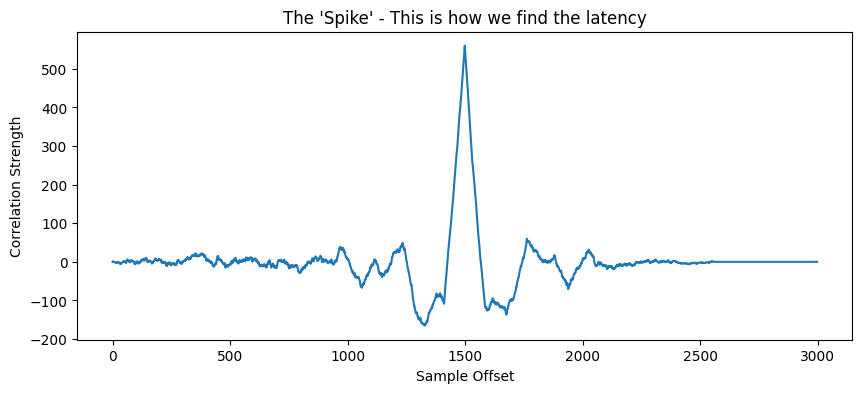

Detected Latency: 500 samples


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def get_correlation_peak(original, recorded):
    # This is the "Full" cross-correlation
    correlation = np.correlate(recorded, original, mode='full')
    return correlation

# Let's simulate a "Recording" with noise and a delay of 500 samples
delay = 500
noise_level = 0.5

# Test with Barker 13
test_signal = barker_signal[:1000] # Use the one from the previous snippet
recorded_signal = np.zeros(2000)
recorded_signal[delay:delay+len(test_signal)] = test_signal
recorded_signal += np.random.normal(0, noise_level, len(recorded_signal)) # Add noise!


# Calculate Correlation
corr = get_correlation_peak(test_signal, recorded_signal)

# Plotting the result
plt.figure(figsize=(10, 4))
plt.plot(corr)
plt.title("The 'Spike' - This is how we find the latency")
plt.xlabel("Sample Offset")
plt.ylabel("Correlation Strength")
plt.show()

# The peak index minus the length of the signal tells you the delay
peak_index = np.argmax(corr) - len(test_signal) + 1
print(f"Detected Latency: {peak_index} samples")

In [5]:
import numpy as np
from scipy.io import wavfile
from IPython.display import Audio, display

sr, x = wavfile.read("./acousticdemo.wav")

# Convert to float in [-1, 1]
if x.dtype == np.int16:
    x = x.astype(np.float32) / 32768
elif x.dtype == np.int32:
    x = x.astype(np.float32) / 2147483648
else:
    x = x.astype(np.float32)

# Stereo → mono
if x.ndim > 1:
    x = x.mean(axis=1)

# Normalize
x /= np.max(np.abs(x))

y = np.sign(x) * np.sqrt(np.abs(x))
y /= np.max(np.abs(y))

z = np.tanh(10 * x)

print("Original")
display(Audio(x, rate=sr))

print("Signed sqrt")
display(Audio(y, rate=sr))

print("Tanh")
display(Audio(z, rate=sr))

Original


/var/folders/p0/_rv7hyx175s58w5dhg463z8w0000gn/T/ipykernel_4125/581364023.py:5: WavFileWarning: Chunk (non-data) not understood, skipping it.
  sr, x = wavfile.read("./acousticdemo.wav")


Signed sqrt


Tanh


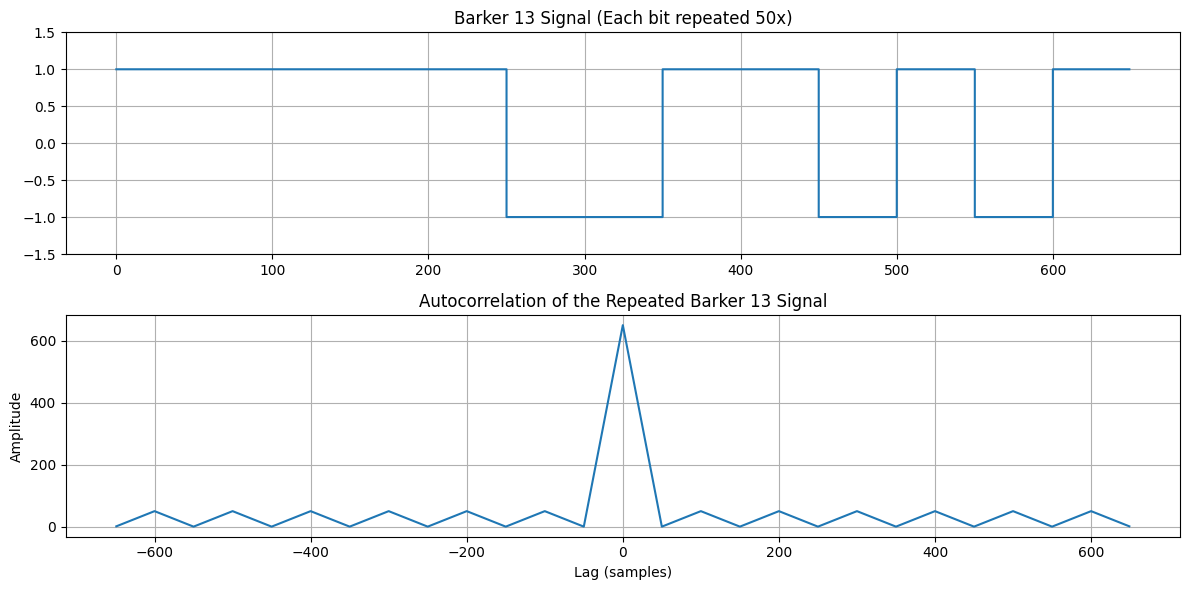

In [3]:
import numpy as np
import matplotlib.pyplot as plt

# 1. Define Barker 13 sequence
# Barker 13: +1, +1, +1, +1, +1, -1, -1, +1, +1, -1, +1, -1, +1
barker13 = np.array([1, 1, 1, 1, 1, -1, -1, 1, 1, -1, 1, -1, 1])

# 2. Repeat each sample 50 times
interpolation_factor = 50
signal = np.repeat(barker13, interpolation_factor)

# 3. Perform cross-correlation (with itself)
# 'full' mode returns the correlation at every possible lag
correlation = np.correlate(signal, signal, mode='full')

# 4. Create time/lag axes for plotting
lags = np.arange(-len(signal) + 1, len(signal))

# Plotting
plt.figure(figsize=(12, 6))

plt.subplot(2, 1, 1)
plt.step(range(len(signal)), signal, where='post')
plt.title(f"Barker 13 Signal (Each bit repeated {interpolation_factor}x)")
plt.grid(True)
plt.ylim(-1.5, 1.5)

plt.subplot(2, 1, 2)
plt.plot(lags, correlation)
plt.title("Autocorrelation of the Repeated Barker 13 Signal")
plt.xlabel("Lag (samples)")
plt.ylabel("Amplitude")
plt.grid(True)

plt.tight_layout()
plt.show()

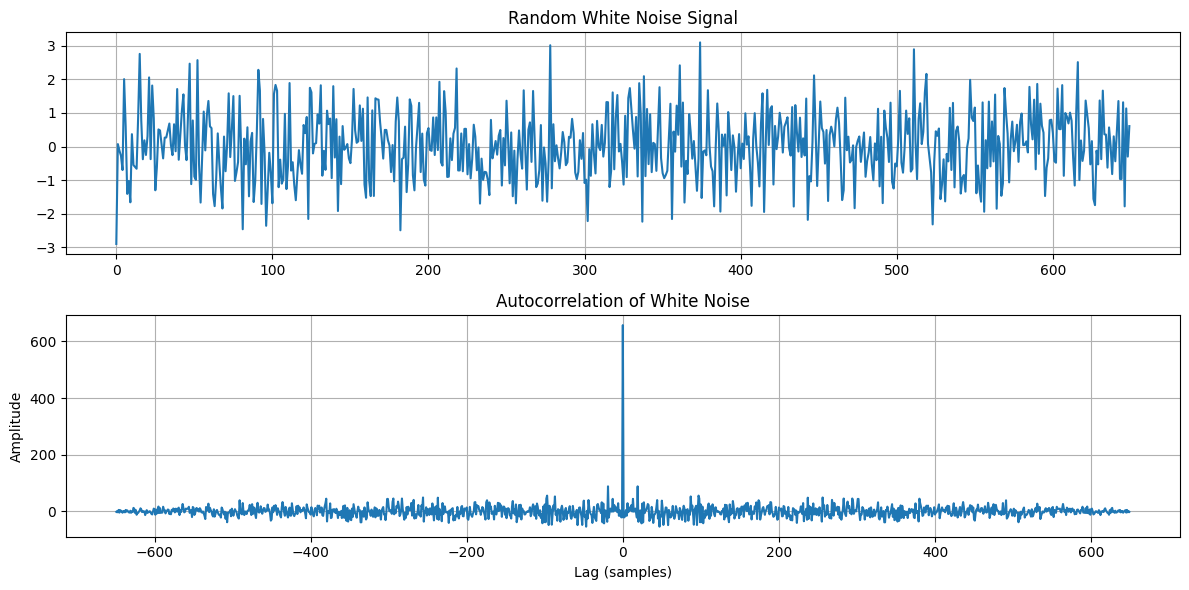

In [4]:
import numpy as np
import matplotlib.pyplot as plt

# 1. Setup parameters
interpolation_factor = 50
num_elements = 13
total_length = num_elements * interpolation_factor

# 2. Generate White Noise signal
# We use a standard normal distribution (mean=0, std=1)
white_noise = np.random.normal(0, 1, total_length)

# 3. Perform cross-correlation
correlation_noise = np.correlate(white_noise, white_noise, mode='full')
lags = np.arange(-len(white_noise) + 1, len(white_noise))

# Plotting
plt.figure(figsize=(12, 6))

plt.subplot(2, 1, 1)
plt.plot(white_noise)
plt.title("Random White Noise Signal")
plt.grid(True)

plt.subplot(2, 1, 2)
plt.plot(lags, correlation_noise)
plt.title("Autocorrelation of White Noise")
plt.xlabel("Lag (samples)")
plt.ylabel("Amplitude")
plt.grid(True)

plt.tight_layout()
plt.show()